# What is a "reasonable" level of Precision & Recall in off-line recommendations

This notebook demonstrates through some simple calculations what a reasonable basline of precision and recall should be under two different settings.

## Modelling Assumptions

Precision and recall measures are defined in a way that assumes a controlled experiment. Given a set of products $\mathcal{P}$ I recommend a subset of them $\mathcal{R}=\{r_1, r_2, ..., r_n\}\subset \mathcal{P}$ and observe what they buy $\mathcal{B}=\{b_1, b_2, ..., b_n\}\subset \mathcal{P}$. The question is how good the overlap is between the recommended and bought items $\mathcal{R}\cup\mathcal{B}$ (true positives). The measure of the overlap is the count of items ($|\mathcal{R}\cup\mathcal{B}|$) and the two measures precision ($\mathbf{P}$) and recall ($\mathbf{R}$) only differn in how we normalize this overlap.

$$\mathbf{P}=\frac{|\mathcal{R}\cup\mathcal{B}|}{|\mathcal{R}|}$$
\
$$\mathbf{R}=\frac{|\mathcal{R}\cup\mathcal{B}|}{|\mathcal{B}|}$$

In an off-line setting, precision and recall needs to be evaluated without actually performing the experiment. A reasonable baseline for evaluating the quality of this these measures would be to see if it differs from what would be expected to get by pure chance. 

## Model 1 - Uniform Random Urn

Let's start with the most simple case where the probability of buying any production is uniform, i.e. $P(b_i) = P(b_j) = p_b\;\;\forall i,j$. 

To define notation, we assume that the setting is as follows: 

- The size of the set of products / categories is $|\mathcal{P}|=\mathtt{nb\_exists}$
- Of these products we recommend $|\mathcal{R}|=\mathtt{nb\_reco}$
- Of the products customers buy $|\mathcal{B}|=\mathtt{nb\_bought}$
- We test this on a number of customers/experiments $\mathtt{nb\_experiments}$.

Obviously, if products are bought at random, then the expected size of the overlap is $E[|\mathcal{R}\cup\mathcal{B}|] = p_b|\mathcal{B}||\mathcal{R}| = p_b*\mathtt{nb\_bought}*\mathtt{nb\_reco}$. Naturally $p_b = \mathtt{nb\_exists}^{-1}$. In this setting both $E[|\mathcal{R}|]$ and $E[|\mathcal{B}|]$ are fixed so we get:

$$E[\mathbf{P}]=\frac{\mathtt{nb\_exist}^{-1}*\mathtt{nb\_bought}*\mathtt{nb\_reco}}{\mathtt{nb\_reco}} = \frac{\mathtt{nb\_bought}}{\mathtt{nb\_exists}}$$
\
$$E[\mathbf{R}]=\frac{\mathtt{nb\_exist}^{-1}*\mathtt{nb\_bought}*\mathtt{nb\_reco}}{\mathtt{nb\_bought}} = \frac{\mathtt{nb\_reco}}{\mathtt{nb\_exists}}$$



Note that we have:
$$\frac{E[\mathbf{P}]}{\mathtt{nb\_bought}} = \frac{E[\mathbf{R}]}{\mathtt{nb\_reco}}=p_b$$
And that:
$$E[\mathbf{P}] = E[\mathbf{R}]\frac{\mathtt{nb\_bought}}{\mathtt{nb\_reco}}$$

In [120]:
nb_exists      = 10
nb_reco        = 3
nb_bought      = 5  # assumed to be distinct categories
nb_experiments = 10000

# for each customer, pull products at random
cat_bought = t(replicate(nb_experiments, sample.int(nb_exists, nb_bought, replace = FALSE)))

# assume that the products have been ordered so that they are indexed in the 
# order we recommend, however we only recommended the top nb_reco items.
tp = apply(cat_bought, 1, FUN = function(x) {sum(x <= nb_reco)})

precision = sum(tp) / (nb_reco   * nb_experiments)
recall    = sum(tp) / (nb_bought * nb_experiments)

print(paste("Precision is:", precision, ". Expeted value is:", nb_bought/nb_exists))
print(paste("Recall is:", recall, ". Expected value is:", nb_reco/nb_exists))

[1] "Precision is: 0.498933333333333 . Expeted value is: 0.5"
[1] "Recall is: 0.29936 . Expected value is: 0.3"


## Model 2 - Unbalanced urn

If the probability of buying different items is not uniform then the above approximation does not hold. If the experiment is large enough and sampled appropriately (no biases) then the unconditional expectations are a good approximation of the expectation (i.e. we can use turnover as a proxy for the probabilities).

In this case we keep the number of bought items $nb\_bought$ fixed, but also only want to count items only once (not counting multiple purchases of the same item). This is non-trivial, but implemented in the R package BiasedUrn. We assume no structure for multiple purchases (only what is dictated by random). This means we will keep drawing from from the urn with the given probability vector until we have $nr\_bought$ unique items purchased, not counting any repeat ransactions - i.e. it is more likely that we will see unpopular items (as measured per turnover) being sold than if we draw random transactions without conditioning on what the customer has previously bought.


In [113]:
#' using the multivariate Wallenius non-cental hypergeometric distribution 
#' we can require that the categories are distinct! This naturally skews
#' the density of the (distinct) categories, but that is just a mathematical
#' result... there will be more purchases in the more popular categories(!) 
#' making the volumes normal in turnover.
library(BiasedUrn) 

nb_exists      = 10
nb_reco        = 3  # assumed to be 1:nb_reco
nb_bought      = 5  # assumed to be distinct categories
nb_experiments = 10000


biased_odds = c(0.4, 0.25, 0.17, 0.09, 0.03, 0.02, 0.015, 0.011, 0.01, 0.004)
unbiased_odds = rep(1/nb_exists, nb_exists)

draws = t(rMWNCHypergeo(nb_experiments, 
                        m = rep(1, nb_exists), 
                        n = nb_bought, 
                        odds = biased_odds))
#
# draws: is a matrix (size: nb_experiments x nb_exists) with an indicator 1 if
#        the customer buys a specific product or not. 
#
#        By summing the columns of draws we get the number of purachses of this 
#        item / in this category
#
#
# NB: The number is actually the number of purchased items in each category, 
#     but we limit the number of purchases to be maximum 1, so multiple 
#     purchases of one item is not inflated.
#
(df = data.frame(item = 1:nb_exists, 
                 observed = apply(draws, 2, sum) / sum(apply(draws, 2, sum)), 
                 biased_odds = biased_odds))


item,observed,biased_odds
<int>,<dbl>,<dbl>
1,0.19804,0.400
2,0.19452,0.250
3,0.18622,0.170
4,0.16212,0.090
5,0.08448,0.030
6,0.05802,0.020
7,0.04254,0.015
8,0.03202,0.011
9,0.02948,0.010


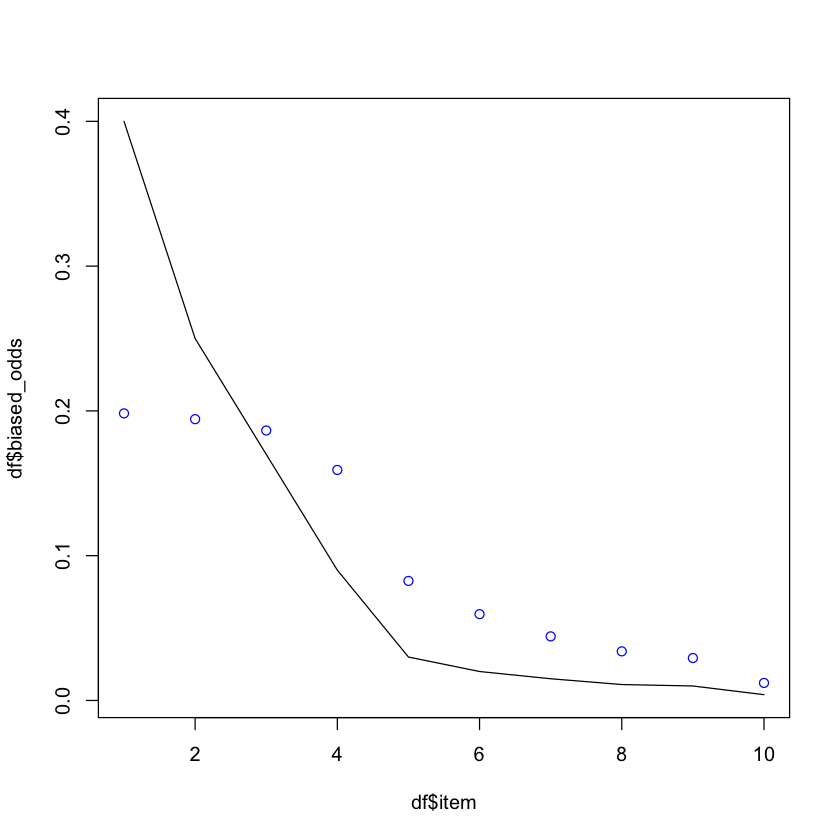

In [111]:
plot(df$item, df$biased_odds, type = 'l')
points(df$item, df$observed, col = "blue")

Note that the observed probabilities do not exceed $1/nb\_bought$ which makes sense!

In [112]:
# for each customer, count the number of true positives 
# (transactions at position between 1 and nb_reco)
tp = apply(draws, 1, FUN = function(x) {sum(x[1:nb_reco])})


(precision = sum(tp) / (nb_reco   * nb_experiments))
(recall    = sum(tp) / (nb_bought * nb_experiments))


# recall    = sum until number of recommendations of the vector apply(draws, 2, sum) / sum(apply(draws, 2, sum))
# precision = recall * nb_bought/nb_reco



[1] 0.9650667

[1] 0.57904

It is now interesting to remember the value of expected recall we have for the unbiased situation:

$$E[\mathbf{R}]=\frac{\mathtt{nb\_reco}}{\mathtt{nb\_exists}} = \mathtt{nb\_reco}*p_b = \sum_{i=1}^{\mathtt{nb\_reco}}p_b$$

This last specification can potentially be generalize by using the conditional probabilities of seeing a transation of an item.

to our setting and we see that it holds true:

In [89]:
sum(df$observed[1:nb_reco])

[1] 0.5809

We also see that the relationship between expected precision and expected recall still holds:
$$E[\mathbf{P}] = E[\mathbf{R}]\frac{\mathtt{nb\_bought}}{\mathtt{nb\_reco}}$$

In [90]:
sum(df$observed[1:nb_reco]) * nb_bought / nb_reco

[1] 0.9681667

## Corollory I
It's interesting to note that in both cases (bias and unbiased urn) we find that:

$$\frac{E[\mathbf{P}]}{E[\mathbf{R}]} = \frac{\mathtt{nb\_bought}}{\mathtt{nb\_reco}}$$

This is an interestig relationship to rember when seeing differences in the ratio of precision to recall over time or between markets. A higher precision-to-recall ratio with a fixed number of recommendations could be a result of higher number of distinct categories being bought.

## Corollory II
For the biased urn case, we find that we can define an equivalent measure to $p_b$ using the same relationships as for the unbiased urn.

$$\frac{E[\mathbf{R}]}{\mathtt{nb\_reco}}= \frac{1}{\mathtt{nb\_reco}}\sum_{i=1}^{\mathtt{nb\_reco}}p_b^i$$

In this case it's simply the average probability of seeing a transaction in one of the recommended products.

In [121]:
sum((df$observed[1:nb_reco])[1:nb_reco]) / nb_reco

[1] 0.1929267

We see that if we define $p^*$ as the relevant average probability:

$$E[\mathbf{P}] = \mathtt{nb\_bought} * p^*$$
\
$$E[\mathbf{R}] = \mathtt{nb\_reco} * p^*$$

- Then it is easy to increase recall by incresing simply increasing the number of recommendations. This has no impact on precision. 
- Increasing the precision is only possible by increasing the number of transactions. This has no impact on recall.